           Variant Format                    Setting Size (human)   PSNR(dB)  \
0   PNG (lossless)    PNG              optimize=True      2.01 MB        inf   
1      JPEG (q=95)   JPEG  quality=95, subsampling=0    473.69 KB  56.709204   
2      JPEG (q=75)   JPEG  quality=75, subsampling=1    305.94 KB  51.654093   
3      JPEG (q=50)   JPEG  quality=50, subsampling=2    248.16 KB  38.799196   
4      JPEG (q=30)   JPEG  quality=30, subsampling=2    143.89 KB  36.807303   
5      WebP (q=90)   WebP                 quality=90    334.03 KB  44.413891   
6      WebP (q=75)   WebP                 quality=75    166.41 KB  39.131108   
7      WebP (q=50)   WebP                 quality=50    120.19 KB  37.071792   
8      WebP (q=30)   WebP                 quality=30     84.92 KB  35.204195   
9  WebP (lossless)   WebP              lossless=True      1.15 MB        inf   

       SSIM  
0  1.000000  
1  0.999266  
2  0.997898  
3  0.972839  
4  0.947122  
5  0.988670  
6  0.961913  
7  0.94

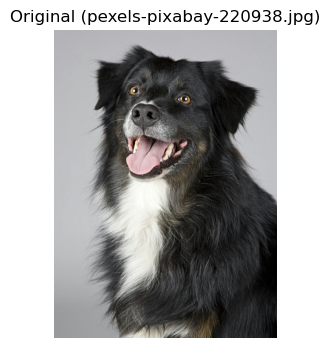

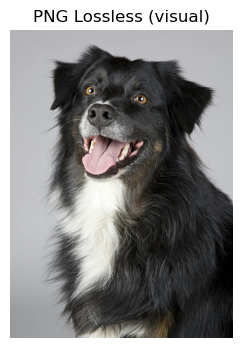

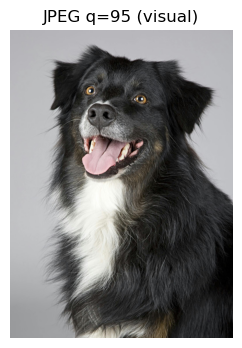

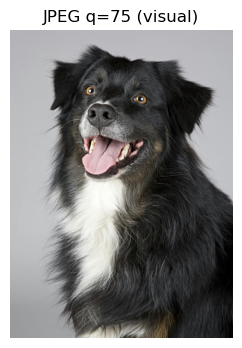

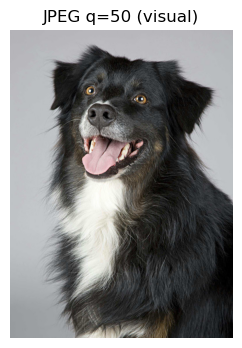

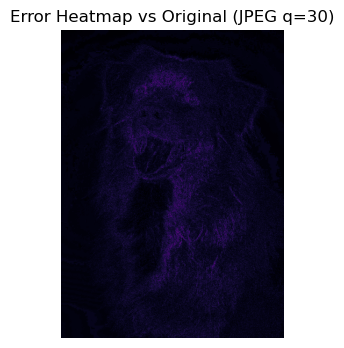

In [2]:
import os
import math
from pathlib import Path
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

# Try importing SSIM
try:
    from skimage.metrics import structural_similarity as ssim
    SKIMAGE_AVAILABLE = True
except Exception:
    SKIMAGE_AVAILABLE = False

# === CHANGE THIS to your input file ===
user_img_path = Path(r"C://Users//LENOVO//Downloads//pexels-pixabay-220938.jpg")

# Output directory (same folder as input)
OUT_DIR = user_img_path.parent

# -----------------------------
# 1. Load image
# -----------------------------
def load_image(path: Path):
    img = Image.open(path)
    if img.mode != "RGB":
        img = img.convert("RGB")
    return img

# -----------------------------
# 2. Quality metrics
# -----------------------------
def mse(img_a: np.ndarray, img_b: np.ndarray) -> float:
    diff = (img_a.astype(np.float64) - img_b.astype(np.float64))
    return np.mean(diff ** 2)

def psnr(img_a: np.ndarray, img_b: np.ndarray, max_val: float = 255.0) -> float:
    m = mse(img_a, img_b)
    if m == 0:
        return float("inf")
    return 20.0 * math.log10(max_val) - 10.0 * math.log10(m)

# -----------------------------
# 3. Compression & measurement
# -----------------------------
def compress_and_measure(img: Image.Image, fmt: str, out_path: Path, **save_kwargs):
    img.save(out_path, format=fmt, **save_kwargs)
    size_bytes = out_path.stat().st_size

    decoded = Image.open(out_path).convert("RGB")
    a = np.array(img)
    b = np.array(decoded)

    psnr_val = psnr(a, b)
    ssim_val = None
    if SKIMAGE_AVAILABLE:
        ssim_val = ssim(a, b, channel_axis=2, data_range=255.0)

    return size_bytes, psnr_val, ssim_val, decoded

def human_size(nbytes: int) -> str:
    units = ["B", "KB", "MB", "GB"]
    size = float(nbytes)
    idx = 0
    while size >= 1024 and idx < len(units) - 1:
        size /= 1024.0
        idx += 1
    return f"{size:.2f} {units[idx]}"

# -----------------------------
# 4. Run compressions
# -----------------------------
img = load_image(user_img_path)
base_name = user_img_path.stem
outputs = []

# --- Lossless PNG ---
png_path = OUT_DIR / f"compressed_{base_name}_lossless.png"
png_size, png_psnr, png_ssim, png_img = compress_and_measure(
    img, "PNG", png_path, optimize=True
)
outputs.append({
    "Variant": "PNG (lossless)",
    "Format": "PNG",
    "Setting": "optimize=True",
    "File": str(png_path),
    "Size": png_size,
    "PSNR(dB)": png_psnr,
    "SSIM": png_ssim
})

# --- JPEG lossy at various qualities ---
jpeg_qualities = [95, 75, 50, 30]
jpeg_files = []

for q in jpeg_qualities:
    subsampling = 0 if q >= 85 else (1 if q >= 60 else 2)
    out = OUT_DIR / f"compressed_{base_name}_jpeg_q{q}.jpg"

    size_b, pval, sval, dec = compress_and_measure(
        img, "JPEG", out, quality=q, optimize=True, subsampling=subsampling
    )
    outputs.append({
        "Variant": f"JPEG (q={q})",
        "Format": "JPEG",
        "Setting": f"quality={q}, subsampling={subsampling}",
        "File": str(out),
        "Size": size_b,
        "PSNR(dB)": pval,
        "SSIM": sval
    })
    jpeg_files.append((q, out, dec))

# --- WebP lossy and lossless (if supported) ---
try:
    for q in [90, 75, 50, 30]:
        out = OUT_DIR / f"compressed_{base_name}_webp_q{q}.webp"
        size_b, pval, sval, dec = compress_and_measure(
            img, "WEBP", out, quality=q, method=6
        )
        outputs.append({
            "Variant": f"WebP (q={q})",
            "Format": "WebP",
            "Setting": f"quality={q}",
            "File": str(out),
            "Size": size_b,
            "PSNR(dB)": pval,
            "SSIM": sval
        })

    out = OUT_DIR / f"compressed_{base_name}_webp_lossless.webp"
    size_b, pval, sval, dec = compress_and_measure(
        img, "WEBP", out, lossless=True, method=6
    )
    outputs.append({
        "Variant": "WebP (lossless)",
        "Format": "WebP",
        "Setting": "lossless=True",
        "File": str(out),
        "Size": size_b,
        "PSNR(dB)": pval,
        "SSIM": sval
    })
except Exception:
    pass

# -----------------------------
# 5. Save comparison table
# -----------------------------
df = pd.DataFrame(outputs)
df["Size (human)"] = df["Size"].map(human_size)

cols = ["Variant", "Format", "Setting", "Size (human)", "PSNR(dB)"]
if SKIMAGE_AVAILABLE:
    cols.append("SSIM")

print(df[cols])

# -----------------------------
# 6. Show results
# -----------------------------
def show_image(im: Image.Image, title: str):
    plt.figure(figsize=(6, 4))
    plt.imshow(im)
    plt.axis("off")
    plt.title(title)
    plt.show()

show_image(img, f"Original ({user_img_path.name})")
show_image(png_img, "PNG Lossless (visual)")

for q, out, dec in jpeg_files[:3]:
    show_image(dec, f"JPEG q={q} (visual)")

# Error heatmap for lowest quality JPEG
if jpeg_files:
    q, out, dec = jpeg_files[-1]
    a = np.array(img).astype(np.float32)
    b = np.array(dec).astype(np.float32)
    diff = np.abs(a - b).mean(axis=2)

    diff_norm = (255 * (diff / (diff.max() if diff.max() > 0 else 1))).astype(np.uint8)

    plt.figure(figsize=(6, 4))
    plt.imshow(diff_norm, cmap="inferno")
    plt.axis("off")
    plt.title(f"Error Heatmap vs Original (JPEG q={q})")
    plt.show()